# Depolarization of echo chambers by a random dynamical nudge

To study the effect of RDN, we use an opinion dynamics model.
For a system of $N$ agents, each agent $i$ has an evolving opinion $x_i(t) \in [-\infty, \infty]$.
For a given issue, agent $i$ has a stance with sign $\sigma(x_i)$ and a conviction with strength $|x_i|$.
Strong convictions correspond to one of two extremes.
Agent opinions change based on their interactions with other agents $A_{ij}(t)$,
the strength of social interactions $K > 0$, and the controversialness of the issue $\alpha > 0$
as in Ref \cite{baumann2020modeling}. The opinion dynamics is given by

$$\dot{x}_i= -x_i + K \left(\sum^{N}_{j=1} A_{ij} (t)  \tanh{(\alpha x_j)}\right) + D \sqrt {n}\left({\bar{X}}_{n}-\langle x \rangle \right) \tag{1}$$

Where $D$ is the RDN strength, $\bar{X}_{n}$ is the mean from a sample (of size $n << N$) of opinions,
and $\langle x \rangle$ is the true mean of all opinions.

## Imports and settings

If in a Colab notebook, this will
1. pull the latest version of ``opinion_dynamics`` from GitHub
1. add ``opinion_dynamics`` to path
1. install/upgrade packages
    - upgrade ``tqdm`` for ``tenumerate`` function
    - upgrade ``tables`` for appending to `hdf5` files without throwing an error.
    - ``vaex`` for large file reading without crashing the session
        - upgrade ``IPython`` for ``vaex`` [see #514](https://github.com/vaexio/vaex/issues/514) (upgrading seems to make colab unhappy and won't display Jupyter widgets).
1. mount your Google Drive (by asking for an authorization code)
1. make `.cache` and `.output` in your Google Drive under `My Drive > Colab Notebooks > opdynamics`
1. create symlinks between Colab's temporary local `.cache` and `.output` and the Google Drive folders for persistence

> Note:
> 1. After installing packages you **must** restart runtime.
> 1. Creating symlinks will fail when running the cell again. This is expected.

In [47]:
#@title Colab Setup { display-mode: "form" }
import sys

# for persisting data across sessions
connect_gdrive = False #@param {type:"boolean"}
cache_dir = ".cache" #param {allow-input: true}

try:
    from google.colab import drive

    # Clone github repository
    GIT_REPO = "https://github.com/ChrisCurrin/opinion_dynamics.git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_REPO}" ./temp

    # add to path
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    !pip install -q --upgrade tqdm tables
    !pip install -q --upgrade vaex IPython

    if connect_gdrive:
        # connect GDrive for retrieving/saving results
        drive.mount('/content/drive')

        # create symlink between a Drive folder and the cache for persistence between sessions
        import os
        try:
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
        except IOError:
            pass
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"

except ModuleNotFoundError:
    print("local notebook")
    if sys.platform == "win32":
        cache_dir = f"D:\\{cache_dir}\opinions"
    pass

local notebook


In [48]:
#@title Imports and settings { display-mode: "form" }
%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten
from matplotlib.collections import PolyCollection

try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.socialnetworks import (SocialNetwork, ConnChamber, ContrastChamber, OpenChamber, SampleChamber,
                                             logger as eclogger,
                                             )
from opdynamics.visualise import (VisSocialNetwork,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.metrics.opinions import calc_distribution_differences, distribution_modality
from opdynamics.visualise import plot_surface_product, plot_surfaces
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.cache import get_cache_dir, set_cache_dir
from opdynamics.utils.constants import *
from opdynamics.visualise.compat import sns_kdeplot

try:
    os.makedirs("output")
except FileExistsError:
    pass

old_cache_dir, new_dir = set_cache_dir(cache_dir)

np.random.seed(1337)
sns.set(context="notebook", style="ticks",
        rc={
            "pdf.fonttype": 42, # embed font in output
            "figure.facecolor":"white",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
logging.basicConfig(level=logging.DEBUG)
logging.getLogger().setLevel(logging.DEBUG)
eclogger.setLevel(logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("asyncio").setLevel(logging.WARNING)

# SocialNetworks

We start by showing the rich *object orientated programming* (OOP) approach to building and running a network that produces echo chambers.

Later, we show how to use `simulation`, which encapsulates a lot of the OOP concepts into a more *functional* approach.

## Define parameters

 Symbol     | Variable | Keyword      | Meaning                                   | Range ($\mathbb{R}$)
------------|----------|--------------|-------------------------------------------|---------------------
 N          | N        | ``N``        | Number of agents                          | $>=1$
 m          | m        | ``m``        | Number of other agents to interact with   | $[1,N)$
 $\alpha$   | α        | ``alpha``    | controversialness of issue                | $>0$
 $K$        | K        | ``K``        | social interaction strength               | $>0$
 $\epsilon$ | ε        | ``epsilon``  | minimum activity level with another agent | $>0$
 $\gamma$   | Υ        | ``gamma``    | power law decay of activity distribution  | $[-\infty, \infty]$
 $\beta$    | β        | ``beta``     | power law decay of connection probability | $[-\infty, \infty]$
 $r$        | r        | ``r``        | probability of a mutual interaction       | $[0,1]$ 
 

In [ ]:
N = 1000
m = 10
alpha = 3
K = 3
epsilon = 1e-2
gamma = 2.1
beta = 3
r = 0.5
# set default activity distribution
activity_distribution = negpowerlaw

## Create SocialNetwork object

An associated `VisSocialNetwork` object is created for quick visualisations.

In [ ]:
sn = SocialNetwork(N, m, K, alpha)
vis = VisSocialNetwork(sn)

## Set activity based on powerlaw distribution

$$F(a) = (\gamma-1) \varepsilon^{\gamma-1} a^{-\gamma} \tag{2}$$

In [ ]:
#@title Show activities for one network { display-mode: "form" }

sn.set_activities(activity_distribution, gamma, epsilon)
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
fig.suptitle("t=0")
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinion(ax=ax[1])

## Social Interactions

$A_{ij}(t)$ is the temporal adjacency matrix, which represents the temporal variability
of interactions \cite{barabasi2005origin}, with $A_{ij}(t)=1$ when there is an input
from agent $j$ to $i$ and $A_{ij}(t)=0$ otherwise. The probabilistic reciprocity
factor $r \in [0, 1]$ determines the chance that a connection is mutually influential,
$(A_{ij}(t)=A_{ji}(t)=1)$. If the interaction is reciprocated, both agents update
their opinions; otherwise, only one of the agents' opinions is updated. For each
instance of the adjacency matrix, interactions are governed by each agent's activity
$a_i \in [\varepsilon, 1]$, the propensity for agent $i$ to interact with $m$ other agents,
and the probability $p_{ij}$ that an active agent $i$ will connect with another agent $j$.
This can lead to the polarization of opinions, where most agents hold a moderate stance on
a binary issue and few, if any, agents have a neutral opinion (Fig. 1(a)).
If active agents have an equal chance of interacting with $m$ other agents regardless of
their stance, then the network can become radicalized, with all agents having the same
stance (Fig. 1(b)).

> a note on implementation
>
> the class `SocialInteraction` (in `opdynamics.dynamics.socialinteractions.py`) handles these dynamics.
>
> it handles calling `get_connection_probabilities` and `get_social_interaction` at each `dt`.
>
> for convenience, arguments for the class and methods are handle by `SocialNetwork.set_social_interactions(beta, r, **kwargs)`.
> This (more or less) calls `SocialInteraction(**kwargs)` and `get_connection_probabilities(beta, **kwargs)` and `get_social_interaction(r)`

### connection probabilities

We define the connection probabilities as a function of the magnitude between two agents' opinions:

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{3}$$

Where $\beta$ is the homophily factor, the tendency for agents with similar opinions to interact with each other:
$\beta = 0$ refers to no interaction preference, and $\beta > 0$ means agents with similar opinions are more likely to interact.
Eq. \ref{conn.eq} is modeled as a power-law decay of connection probabilities with only a small chance for agents with opposite
opinions to interact. Due to most interactions occurring between agents with similar opinions, this can lead to the formation of
echo chambers (Fig. \ref{od1.fig}(d)). We instantiate $p_{ij}$ based on the initial uniform distribution of
opinions $x_i \sim \mathcal{U}(0,1)$ \cite{baumann2020modeling}.

These results held whether the temporal network $A_{ij}(t)$ was determined by an initial $p_{ij}$ or one that was
determined at every time point $p_{ij}(t)$ (`sn.set_social_interactions(beta, r, update_conn=True)`).

### mutual interactions

Every interaction from $j$ to $i$ has a chance $r$ of being reciprocal/mutual. That is, $r=0$ means a directed graph of
interactions, one-way influence, and $r=1$ means an undirected graph of connections and a symmetrical adjacency matrix.

- The matrices are computed at each time step $dt$ and then either
    - stored if `store_all=True` (*warning: can use a lot of RAM!*)
    - thrown away if `store_all=False`; the cumulative interactions are still kept.
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
    - `clustermap`
    - `heatmap`
    - `mesh`
    
    Interactions can be sorted using `sort=True` for plotting to identify clusters

In [ ]:
#@title Set social interactions and show connection probabilities

sn.set_social_interactions(beta, r, store_all=True)

fig, ax = vis.show_connection_probabilities("mesh", sort=True,
                                  cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                                  cbar_kws=dict(pad=0.05))
# move label to title
move_cbar_label_to_title(fig)


## Opinion dynamics (without RDN)

In [ ]:
sn.set_dynamics()

## Run and plot results

In [ ]:
dt = 0.01
T = 5
# use Euler for a pretty progress bar, RK45 otherwise.
sn.run_network(dt=dt, t_dur=T, method='Euler')

# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0], title=True)     # markers
vis.show_opinions(color_code='line', ax=ax[1], title=False)  # lines
vis.show_opinions(color_code=False, ax=ax[2], title=False)   # agents uniquely coloured
sns.despine(fig)

## Adjacency matrix 




In [ ]:
vis.show_adjacency_matrix("mesh", sort=False)
vis.show_adjacency_matrix("clustermap", sort=False)
vis.show_adjacency_matrix("heatmap", sort=True, square=True)

## Save/Load

Given the same parameters, a network can be restored without explicitly calling `run_network`. 

A simulation is saved using `sn.save(only_last=True)`. If `only_last` is `False`, the entire duration of the simulation is saved.

If a simulation exists for the network parameters, `sn.load()` restores the saved states and returns `True` (returns `False` otherwise).

In [ ]:
filename = sn.save()
new_ec = SocialNetwork(N, m, K, alpha)
new_ec.set_activities(activity_distribution, gamma, epsilon)
new_ec.set_social_interactions(beta, r, store_all=False) # note only the `r` is the important parameter
new_ec.set_dynamics()
loaded = new_ec.load(dt, T)
if not loaded:
    print("run network")
    new_ec.run_network(dt, T)
else:
    print("results loaded")

# Figure 1

> The convenient `Simulation.run_params` static method is used.

In [ ]:
# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion (not shown)

Low controversialness

- $K = 3$
- $\alpha = 0.05$
- $\beta = 2$

In [ ]:
ec_neutral = Simulation.run_params(SocialNetwork, N=N, m=m, **param_set['neutral'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")

## Polarisation of opinions (1a)

Strong social interactions ($K$), controversial issue ($\alpha$), and greater chance of connecting with people with similar opinions ($\beta$)

- $K = 3$
- $\alpha = 3$
- $\beta = 3$


In [ ]:
ec_polar = Simulation.run_params(SocialNetwork, N=N, m=m, **param_set['polar'],
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                 dt=dt, T=T, plot_opinion=True,
                                 cache="all")
# plt.savefig("output/fig1a.pdf")

## Radicalisation of opinions (1b)

Uniform connection probabilities

- $K = 3$
- $\alpha = 3$
- $\beta = 0$

In [ ]:
ec_radical = Simulation.run_params(SocialNetwork, N=N, m=m, **param_set['radical'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")


*for moderate $\beta$, a polarised network may turn radical.*

In [ ]:
T=20
ec_polar_radical = Simulation.run_params(SocialNetwork, N=N, m=m,
                                         K=3, alpha=3, beta=0.6,
                                         activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                         dt=dt, T=T, plot_opinion=False,
                                         cache="all")
vis = VisSocialNetwork(ec_polar_radical)
fig, axs = plt.subplots(2, 2, sharex='row', sharey=False)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
fig.subplots_adjust(hspace=0.3)
vis.show_opinions(color_code='line', subsample=2, lw=1, ax=axbig)
vis.show_opinions_distribution(t=5.0, ax=axs[1,0], kde_kws=dict(bw_adjust=0.1), , fill=True title=f"5")
vis.show_opinions_distribution(ax=axs[1,-1], fill=True, title=f"{T}")

## Activity vs Opinion (1c)
Polarised param set
- $r = 0.65$

> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N=1000
m=10
T=5
activity_distribution=negpowerlaw
epsilon=1e-2
gamma=2.1
dt=0.01
r=0.65

# how many simulations to run
try:
    from google.colab import drive
    num_states = 1000
except ModuleNotFoundError:
    num_states = 10
# where to save the file
file_name = ".cache/activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        sn = Simulation.run_params(SocialNetwork,N=N, m=m, **param_set['polar'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, store_all=False, 
                                   cache=False, # don't cache time portion
                                   seed=i)
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": sn.activities,
                           "opinion": sn.opinions
                          })
        # save to disk for use later
        hdf.append(f"d{i}", df)


# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)

# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])

# plot everything
# (very good idea to rasterize for saving)
fig, ax, cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                         bins=N, norm=LogNorm(vmin=1/N),
                                         cbar_kws=dict(cax=True),
                                         s=0.1, rasterized=True)
ax.set_ylim(0, 0.5)
sns.despine()

# clear up some ram
del df_ao


## Nearest Neighbour (1d)

In [ ]:
vis = VisSocialNetwork(ec_polar)

levels=10

g = vis.show_nearest_neighbour(bw_adjust=0.5, color=sns.cubehelix_palette(levels, reverse=True)[levels//2],
                               cmap=sns.cubehelix_palette(levels, reverse=True, as_cmap=True), levels=levels,
                               thresh=0)
# adjust limits based on xaxis
from scipy import stats
x_data, y_data = g.ax_marg_x.get_lines()[0].get_data()
s = stats.describe(y_data)
low_bound = np.max(s.mean-s.variance, 0)
mask = (low_bound < y_data)
lim = x_data[mask][0]*1.5, x_data[mask][-1]*1.5
g.ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
g.ax_joint.set_ylim(*lim)

## Generate figure 1

In [ ]:
from opdynamics.utils.plot_utils import move_cbar_label_to_title
with sns.plotting_context("paper"):
    # create figure and grid
    fig = plt.figure(figsize=(3.375, 2.618), dpi=200)
    gs = gridspec.GridSpec(nrows=2, ncols=2, wspace=1.1, hspace=0.9,
                           left=0.18, right=0.97, bottom=0.15,
                           height_ratios=[1,1.618])
    gs_trace_1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,0],
                                                  width_ratios=[1, 0.15],
                                                  wspace=0.1)
    gs_trace_2 = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[0,1],
                                                  width_ratios=[1, 0.15],
                                                  wspace=0.1)
    gs_activity = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[1,0],
                                                  width_ratios=[1, 0.1],
                                                  wspace=0.1)
    gs_nn = gridspec.GridSpecFromSubplotSpec(2, 2,  subplot_spec=gs[1,1],
                                             width_ratios=[1, 0.1], height_ratios=[0.1, 1],
                                             wspace=0.1, hspace=0.1)
    # create axes
    ax_trace_1 = fig.add_subplot(gs_trace_1[0])
    ax_dist_1 = fig.add_subplot(gs_trace_1[1], sharey=ax_trace_1)
    ax_trace_2 = fig.add_subplot(gs_trace_2[0])
    ax_dist_2 = fig.add_subplot(gs_trace_2[1], sharey=ax_trace_2)
    ax_activity = fig.add_subplot(gs_activity[0])
    ax_activity_cax = fig.add_subplot(gs_activity[1])
    ax_joint = fig.add_subplot(gs_nn[1,0])
    ax_marg_x = fig.add_subplot(gs_nn[0,0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gs_nn[1,1], sharey=ax_joint)

    # Make the grid look nice
    sns.despine(fig)
    sns.despine(ax=ax_dist_1, left=False, bottom=True)
    sns.despine(ax=ax_dist_2, left=False, bottom=True)
    ax_dist_1.tick_params(labelleft=False, bottom=False, labelbottom=False)
    ax_dist_2.tick_params(labelleft=False, bottom=False, labelbottom=False)
    sns.despine(ax=ax_marg_x, left=True)
    sns.despine(ax=ax_marg_y, bottom=True)

    # polarised opinions trace
    vis = VisSocialNetwork(ec_polar)
    vis.show_opinions(ax=ax_trace_1, color_code='line', subsample=10, lw=0.5, title="Polarised", rasterized=True)
    vis.show_opinions_distribution(ax=ax_dist_1, kde_kws=dict(bw_adjust=0.15), vertical=True, title=False)

    # radicalised opinions trace
    vis_radical = VisSocialNetwork(ec_radical)
    vis_radical.show_opinions(ax=ax_trace_2, color_code='line', subsample=2, lw=1, title="Radicalised", rasterized=True)
    vis_radical.show_opinions_distribution(ax=ax_dist_2, kde_kws=dict(bw_adjust=0.15), vertical=True, title=False)

    # activity vs opinion
    file_name = ".cache/activity_vs_opinion.h5"
    with pd.HDFStore(file_name) as hdf:
        df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])
    _,_,cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                        ax=ax_activity,
                                        bins=N, norm=LogNorm(vmin=10/N),
                                        cmap='Spectral_r',
                                        cbar_kws=dict(cax=ax_activity_cax),
                                        s=0.01, rasterized=True, title=False)
    cbar.outline.set_visible(False)
    del df_ao

    # nearest neighbour
    show_jointplot(ec_polar.opinions, ec_polar.get_nearest_neighbours(),
                   ax=(ax_joint, ax_marg_x, ax_marg_y))

    # cleaning
    ax_trace_1.set_ylim(-5, 5)
    ax_trace_2.set_ylim(-5, 5)
    ax_trace_1.set_xticks([0,5,10])
    ax_trace_2.set_xticks([0,5,10])
    ax_dist_1.set_ylabel("")
    ax_dist_2.set_ylabel("")
    ax_dist_1.set_xlabel("")
    ax_dist_2.set_xlabel("")
    ax_dist_1.set_xlim(0, 0.7)
    ax_dist_2.set_xlim(0, 1.4)
    ax_activity.set_ylim(0, 0.5)
    ax_activity.set_xlim(-10, 10)
    move_cbar_label_to_title(ax_activity_cax)

    ax_joint.set_xlim(-5, 5)
    ax_joint.set_ylim(-5, 5)
    ax_joint.set_xlabel(OPINION_SYMBOL)
    ax_joint.set_ylabel(MEAN_NEAREST_NEIGHBOUR)

    for letter, _ax in zip(string.ascii_lowercase, [ax_trace_1,ax_trace_2, ax_activity, ax_marg_x]):
        _ax.annotate(f"({letter})", xy=(0, 1), xycoords="axes fraction",
                        xytext=(-27, 5), textcoords="offset points",
                        va="bottom", ha="right")
    # reduce space between axes labels and axes
    for _ax in flatten(fig.axes):
        _ax.yaxis.labelpad=0
        _ax.xaxis.labelpad=0
    fig.savefig("output/fig1.pdf")


# NoisySocialNetwork

Add noise to the system

$\dot{x}_i= -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)  + D [\rm nudge]$


 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $D$         | ``D``        |``NoisySocialNetwork(SocialNetwork)`` | Strength of noise/nudge                                         | $>=0$


## Open system (external noise)

$\dot{x}_i = -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)+ D \cdot \xi (t)$

 Symbol        | Class (inherits from)             | Meaning
---------------|-----------------------------------|---------------
 $\xi(t)$      | ``OpenChamber(NoisySocialNetwork)`` | [Wiener process](https://en.wikipedia.org/wiki/Wiener_process)
 $\dot{\xi}$   | ``OpenChamber(NoisySocialNetwork)`` | Derivative $\mathcal{N}(0,\sqrt{dt})$


In [ ]:
#@title Nudge strength ($D$)

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=5,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D_range = [0, 0.01, 0.1, 0.5, 1, 10]
nec_arr = Simulation.run_product({'D':{'range':D_range}}, plot_opinion=True, **kwargs)
fig = plt.gcf()
fig.subplots_adjust(hspace=-0.5)
for ax in fig.axes:
    ax.set_facecolor("None")
    sns.despine(ax=ax, bottom=True, left=True)
    ax.tick_params(bottom=False, left=False, labelleft=False)
# fig.savefig("output/noise.pdf")
logging.getLogger().setLevel(logging_level)

In [ ]:
#@title Check `dt`

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=1,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.001,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
product_vars = {
    'D': {
        'range': D_range,
    },
    'dt': {
        'range': np.arange(0.001, 0.01+0.001, 0.001)
        }
    }
Simulation.run_product(product_vars,
                       plot_opinion=True, title="dt",
                       label_precision=3, **kwargs)
fig = plt.gcf()
fig.savefig("output/dt.pdf")
logging.getLogger().setLevel(logging_level)

In [ ]:
#@title α, β

kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )

D_range = np.round(np.arange(0.0, 1.1, 0.1), 1)

parameters = {
    'D': {
        'range': D_range,
    },
    'beta':  {
        'range': [0, 1, 2, 3],
        'title': "$\\beta$",
    },
    'alpha': {
        'range': [0.001, 1, 2, 3], 
        'title': "$\\alpha$",
    },
}
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

df = Simulation.run_product(parameters, **kwargs)

logging.getLogger().setLevel(logging_level)

with sns.plotting_context("talk"):
    max_range = max([other['range'] for other in parameters.values()], key=len)
    fig, ax = plt.subplots(len(parameters),len(max_range), sharey=True, sharex=True, squeeze=False)
    fig.subplots_adjust(hspace=0.8)
    for i, (key, other) in enumerate(parameters.items()):
        show_noise_panel(df, key,
                         kde_kwargs=dict(bw_adjust=0.1, cut=2),
                         ax=ax[i])
        for _ax in ax[i]:
            _ax.set_title(f"{other['title']}={_ax.get_title()}")
            _ax.set_xlabel("")
            _ax.set(xlim=(-5,5), ylim=(0, 1))

    sns.despine(fig=fig)
    for _ax in ax[-1]:
        _ax.set_xlabel(math_fix(f"${OPINION_SYMBOL}$"))
    fig.savefig(f"output/{list(parameters.keys())}_grid.pdf")


### Delayed noise

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              activity_distribution = negpowerlaw,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D=0.5

noise_start = 10.
noise_length = 10.
recovery = 10.
num = 1
interval = 0
nsn = Simulation.run_periodic_noise(noise_start, noise_length, recovery, interval=interval, num=num, 
                                    **kwargs,
                                    D=D, plot_opinion=True)
# fig = plt.gcf()
# fig.savefig("output/delayed_noise.pdf")
logging.getLogger().setLevel(logging_level)


## Internal noise

### Dynamic connections

 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $P(-\beta)$ | ``p_opp``    |``ConnChamber(SocialNetwork)``      | Probability of interacting with an agent of opposing opinion    | $[0,1]$


DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.6}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.6})(t).
INFO:MainThread:SocialNetwork:done running SocialNetwork


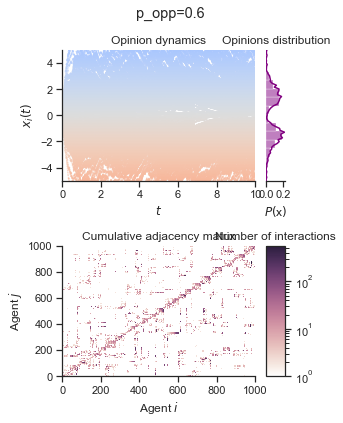

In [108]:
#@title Dynamic connections { run: "auto", vertical-output: true }

# polar opinions
N = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw
dt = 0.01
T = 10

p_opp = 0.6 #@param {type:"slider", min:0, max:1, step:0.05}

cc = Simulation.run_params(ConnChamber, N=N, m=m, K=K, alpha=alpha, beta=beta,
                      activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                      dt=dt, T=T, 
                      p_opp=p_opp,
                      cache="all", 
                      method='Euler',
                      plot_opinion=False,
                      )

with sns.plotting_context():
    vis = VisSocialNetwork(cc)
    fig, ax = plt.subplots(2, 2, figsize=(4,6), gridspec_kw=dict(width_ratios=[1,0.1]))
    vis.show_opinions(ax=ax[0,0])
    fig.subplots_adjust(wspace=0.1, hspace=0.5)
    vis.show_opinions_distribution(ax=ax[0,1], vertical=True, kde_kws=dict(bw_adjust=0.1))
    vis.show_adjacency_matrix("mesh", sort=True,
                                      cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                                      cbar_kws=dict(pad=0.05, cax=ax[1,1]),
                                      ax=ax[1,0]
                                      )
    move_cbar_label_to_title(ax[1,1])
    for _ax in ax[0,:]:
        _ax.set_ylim(-5,5)
    sns.despine()
    sns.despine(ax=ax[0,1], left=True)
    ax[0,1].set_ylabel("")
    ax[0,1].set_yticks([])
    fig.suptitle(f"p_opp={p_opp}")
    fig.set_facecolor('w')


DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.0, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.0})(t).
INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.0, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3

DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.3, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.3})(t).
INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.3, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.3})(t).
INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpow

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.6, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.6})(t).
INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.6, 'seed': 7988657}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initi

SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\44029932817261860835081603656308467959694196850485019662098784833080270903454.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.6, 'seed': 15379820}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.6})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\38445032556802468501506138549082051636966053853393770566978233736839490145594.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.7, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.7})(t).


write to file


INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.7, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.7})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\60203717934800545962020607308779977049238615087076450394273412831525859368999.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.7, 'seed': 7988657}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.7})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...


write to file


DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\61428477397249110238812792456196774098608930410459089067786233898427079480344.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.7, 'seed': 1572039}


write to file


DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.7})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\95361830219789696227991637048397016023670694485935848356869408092863617788710.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.7, 'seed': 15379820}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.7})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\81891996193066166742099046941809058032902248158619872088208705452353131725345.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.8, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.8})(t).


write to file


INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.8, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.8})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\113953741186217767770696583232748623490035277215140992909809808344897290033860.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.8, 'seed': 7988657}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.8})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\42782378809998244506752730570560676079213404281137987046404247605854843004856.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map


write to file


DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.8, 'seed': 1572039}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.8})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:02<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\21619624718557239146404522785812391654491306696607565771554708741107426905310.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.8, 'seed': 15379820}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.8})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...


write to file


DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\52280093356255050882057419316061506800874658782095208567881258642486409538700.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.9, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.9})(t).


write to file


INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.9, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.9})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\14531521651543960066773462969119852190202180328475658911777972535931168559749.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map


write to file


DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.9, 'seed': 7988657}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.9})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\90522537435227721830027421406122733932803579989663013381464565823467268061633.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.9, 'seed': 1572039}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.9})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\73672706489092478635568236621487386737561788019676358700183227316314390407279.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 0.9, 'seed': 15379820}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":0.9})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...


write to file


DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\24553160838239969759078161625007407913127672720901213742387048458757232470232.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 1.0, 'seed': 1337}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":1.0})(t).


write to file


INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 1.0, 'seed': 10725983}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":1.0})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\110955311673087862909873564258643497419015777485802155414389497497648746204762.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 1.0, 'seed': 7988657}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":1.0})(t).


write to file


INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:solvers:1001 iterations to do...


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\24563861534228013877332592820711660265668283275252158074901616786135105191069.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 1.0, 'seed': 1572039}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":1.0})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread:

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\47495646243459807499233286906447903256255405563720976703003191412730259493335.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map
DEBUG:MainThread:simulation:run_params for ConnChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=False)
DEBUG:MainThread:simulation:additional args=()	additional kwargs={'p_opp': 1.0, 'seed': 15379820}
DEBUG:MainThread:social interaction:Social Interaction for SocialNetwork initialised Aij[r=0.5] get_connection_probabilities_opp({"beta":3,"p_opp":1.0})(t).
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:MainThread:solvers:solving ODE using Euler
INFO:MainThread

write to file


SocialNetwork:   0%|          | 0/1001 [00:00<?, ?it/s]

INFO:MainThread:SocialNetwork:done running SocialNetwork
DEBUG:MainThread:social interaction:saving full adj_mat to 'D:\.cache\opinions\81896180019893973183632820208821412901689081986896175429941577972562719166748.npz'
DEBUG:MainThread:social interaction:...saved full adj_mat and deleted memory map


write to file


,$x$,$p_{opp}$
0,1.328681,0.0
1,-1.313321,0.0
2,0.936794,0.0
3,1.499631,0.0
4,1.301324,0.0
...,...,...
54995,-1.449761,1.0
54996,-0.557987,1.0
54997,-0.785545,1.0
54998,-0.729159,1.0


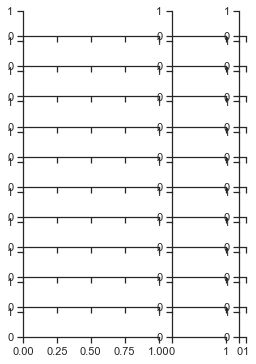

In [140]:
P_OPP = "$p_{opp}$"
p_opp_df = pd.DataFrame()
p_opps = np.round(np.arange(0, 1.01, 0.1), 2)
seeds = [1337, 10725983, 7988657, 1572039, 15379820]
with sns.plotting_context():

    fig, ax = plt.subplots(len(p_opps), 3, figsize=(4,6), gridspec_kw=dict(width_ratios=[1, 0.4, 0.05]),
                          sharex='col', sharey='col')
    bins = 100
    for i, p_opp in enumerate(p_opps):
        for seed in seeds:
            cc = Simulation.run_params(ConnChamber, N=N, m=m, K=K, alpha=alpha, beta=beta,
                                      activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                      dt=dt, T=T, 
                                      p_opp=p_opp,
                                      seed=seed,
                                      cache="all", 
                                      method='Euler',
                                      plot_opinion=False,
                                      )
            temp_df = pd.DataFrame({OPINION_SYMBOL: cc.opinions})
            temp_df[P_OPP] = p_opp

            p_opp_df = p_opp_df.append(temp_df, ignore_index=True)
        
#         if bins is None:
#             hist, bins = np.histogram(cc.opinions, bins="auto")
#         vis = VisSocialNetwork(cc)
#         vis.show_opinions_distribution(ax=ax[i,0], vertical=False, 
#                                        bins=bins, kde_kws=dict(bw_adjust=0.1),
#                                        title=f"")
#         vis.show_adjacency_matrix("mesh", sort=True,
# #                                   cmap=sns.cubehelix_palette(light=1, as_cmap=True),
#                                   cbar_kws=dict(pad=0.05, cax=ax[i,2]),
#                                   ax=ax[i,1],
#                                   title="",
#                                           )
#         ax[i,0].set_ylabel(f"$p_{{opp}}$ = {p_opp}", rotation=0, ha="right")
#     ax[0,0].set_xlim(-5,5)
p_opp_df

C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.ti

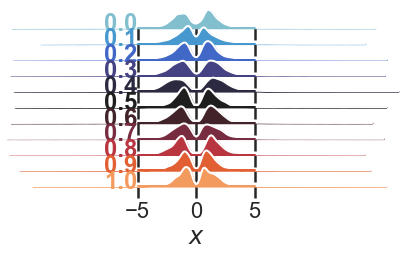

In [144]:
with sns.plotting_context("poster"):
    plt.rcParams["axes.facecolor"] = "None"
    pal = sns.cubehelix_palette(len(clt_method_names), rot=-.25, light=.7)
    g = sns.FacetGrid(p_opp_df, 
                      row=P_OPP,
                      hue=P_OPP, 
                      aspect=7, height=.3, palette="icefire")
    
    bw_adjust = 0.5
    # Draw the densities in a few steps
    g.map(sns.kdeplot, OPINION_SYMBOL,
          bw_adjust=bw_adjust, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, OPINION_SYMBOL, clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label, fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)
    g.map(label, OPINION_SYMBOL)
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], xlim=(-5,5))
    g.despine(bottom=True, left=True)
#     g.axes.flat[-1].set_xticks(range(-4, 6,2))
    g.savefig("output/p_opp.pdf")

### Contrastive noise

Noise comes from exposing each agent to a random other agent, $x_k$, independent of $\beta$.

Either
1. Contrast own opinion with another
$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_i - x_k)))$
1. Show another agent's opinion
$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_k)))$


 Symbol        | Keyword      | Class (inherits from)                  | Meaning
---------------|--------------|----------------------------------------|---------------
 $x_k$         | ``k_steps``  | ``ConstrastChamber(NoisySocialNetwork)`` | Another agent chosen every $k$ time steps.
 $\alpha_2$    | ``alpha_2``  | ``ConstrastChamber(NoisySocialNetwork)`` | Scaling of agent's opinion (or difference of opinions)



#### Params vs noise

In [ ]:
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              k_steps=10,
              cls=ContrastChamber
             )

D_range = np.round(np.arange(0.0, 0.5, 0.05), 3)

parameters = {
    'D':{
        'range': D_range,
        'title': 'D',
    },
    'k_steps':{
        'range':[1, 100],
        'title':'k',
    },
    'alpha_2':{
        'range':[0.01, 0.1, 1, 10],
        'title':'$\alpha_2$',
    },
}
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
noise_start = 0
            
df = Simulation.run_product(parameters,
                            noise_start=noise_start,
                            **kwargs)
logging.getLogger().setLevel(logging_level)

In [ ]:
grid_kwargs = dict(sharex=False, sharey=False, margin_titles=True, legend_out=True)
kde_kwargs = dict(bw_adjust=0.01)
g = show_opinion_grid(df, ['alpha_2','D','k_steps'], grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.add_legend(fontsize='large')

In [ ]:
g = show_opinion_grid(df, [x for x in parameters.keys() if x != "D"],
                    grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, sn='None', s=1)

## SampleChamber

The Central Limit Theorem states...

> Sample means are normally distributed.

> The mean of sample means approximates the true mean of the population.

In [ ]:
#title Set up polarised opinions { display-mode: "form" }

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01
K=3
alpha=3
beta=3

ec_polar = Simulation.run_params(SocialNetwork, N=N, m=m,
                                 K=K, alpha=alpha, beta=beta,
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                 dt=dt, T=T, plot_opinion=True, cache="all")

In [ ]:
#title Check sample size and number of samples { run: "auto", display-mode: "form" }

sample_size = 30 #@param {type:"slider", min:1, max:1000, step:1}
num_samples = 1000 #@param {type:"slider", min:1, max:1000, step:1}

fig, ax = plt.subplots()

sample_means = ec_polar.get_sample_means(sample_size, num_samples)
mu = np.mean(sample_means)

sns.distplot(sample_means)

ax.annotate(f"$\mu' = {mu:.4f}$", xy=(mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='bottom', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
true_mu = np.mean(ec_polar.opinions)
ax.annotate(f"$\mu = {true_mu:.4f}$", xy=(true_mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='top', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
ax.set_xlabel(f"$\overline{{X}}_n$\n[$n$ = {sample_size}]")
ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")


Add a "population opinion" term that captures the Lindeberg–Lévy Central Limit Theorem.


$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D \cdot \sqrt {n}\left({\bar{X}}_{n}-\mu \right)$

where $X$ is a random sample and $\bar{X}_{n}$ is the sample mean for $n$ random samples.

According to CLT, the means of random samples are normally distributed.

By substracting the true (or accurate estimate of the ) mean, $\mu$, and scaling by sample size ($\sqrt{n}$),
the normal distribution is centered on $0$.

$\sqrt {n}\left({\bar{X}}_{n}-\mu \right) \rightarrow \mathcal{N}\left(0,\sigma^{2}\right)$

 Symbol      | Keyword          | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|------------------|----------------------------------|----------------------------------------------------------|---------------------
 $n$         | ``sample_size``  |``SampleChamber(NoisySocialNetwork)``      | Number of opinions to sample from all agents    | $[0,N]$


In [ ]:
#@title SampleChamber playground { vertical-output: true }

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5 #@param {type:"slider", min:0, max:10, step:1}
# Nudge arguments
D = 0 #@param {type:"slider", min:0, max:20, step:0.5}
sample_size = 10 #@param {type:"slider", min:1, max:100, step:1}
sample_method = "basic" #@param ["basic", "outer_sigmoid", "inner_sigmoid", "subsample"]

integration_method = "RK45" #@param ["Euler", "RK45"]
iterations = 1 #@param {type:"slider", min:1, max:20, step:1}
with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    fig, axs = plt.subplots(2, 3, gridspec_kw=dict(width_ratios=[1, 1, 0.1],
                                                   height_ratios=[0.1, 1]),
                            sharey="row", sharex="col")
    (ax_empty, ax_marg_x, ax_empty_2), (ax_opinions_t, ax_joint, ax_marg_y) = axs
    ax_empty.remove()
    ax_empty_2.remove()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    palette = sns.color_palette("husl", n_colors=iterations)

    seeds = np.geomspace(1, 100000, num=20, dtype=int)

    nn = np.empty(N*iterations)
    x = np.empty(N*iterations)

    for i in range(iterations):
        sc = Simulation.run_params(cls=SampleChamber, N=N, m=m, K=K, alpha=α, beta=β,
                                   activity=activity_distribution, gamma=Υ, epsilon=ε,
                                   r=r, dt=dt, T=T, D=D,
                                   sample_size=sample_size, sample_method=sample_method,
                                   method=integration_method,
                                   plot_opinion=False,
                                   seed=seeds[i], cache="all")

        vis = VisSocialNetwork(sc)
        vis.show_opinions(color_code='line', ax=ax_opinions_t,
                          title=f"D={D}, n={sample_size} ({sample_method})\n"
                                f"K={K}, α={α}, β={β}\n"
                                f"N={N}, m={m}\nε={ε}, Υ={Υ}\n"
                                f"dt={dt} ({integration_method})"
                          )
        nn[i*N:(i+1)*N] = sc.get_nearest_neighbours()
        x[i*N:(i+1)*N] = sc.opinions

    show_jointplot(nn, x,
                    ax=(ax_joint, ax_marg_x, ax_marg_y),
                    marginal_kws=dict(bw=0.5))

    ax_opinions_t.set_ylim(-5,5)
    ax_joint.set_xlim(-5,5)
    ax_joint.set_xlabel(MEAN_NEAREST_NEIGHBOUR)

    logging.getLogger().setLevel(logging_level)

### Run parameter sweep

In [ ]:
logging_level = logging.getLogger().getEffectiveLevel()
eclogger.setLevel(logging.INFO)
logging.getLogger().setLevel(logging.INFO)

parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
    cls=SampleChamber,
    method="Euler",
)

D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)

sample_size_range = np.arange(1, 50.0001, 1, dtype=int)

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [1, 2, 3], "title": "α"},
    "beta": {"range": [1, 2, 3], "title": "β"},
    "K": {"range": [1, 2, 3], "title": "K"},
}

cache_sim_name = "noise_source.h5"

run_range_parameters = (
    range_parameters if os.path.exists(f"{get_cache_dir()}/{cache_sim_name}") else None
)

df = Simulation.run_product(
    run_range_parameters,
    noise_start=0,
    cache=True,
    cache_sim=cache_sim_name,
    parallel=True,
    **parameters
)
logging.getLogger().setLevel(logging_level)

### Plot

In [ ]:
grid_kwargs = dict(sharex=True, sharey=False,
                   margin_titles=True, legend_out=True)
kde_kwargs = dict(bw_adjust=0.01)

sub_df = df[
    (df["D"].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])) & (df["sample_size"].isin([1, 10]))
]

defaults = {
    'D': 'col',
    'sample_size': 'row',
    'alpha': 3,
    'K': 3,
    'beta': 3,
}
import ipywidgets as widgets
pickers = {}
for key in range_parameters:
    if key in sub_df.columns:
        unique = sub_df[key].unique()
        desc = range_parameters[key]['title'] if 'title' in range_parameters[key] else key
        pickers[key] = widgets.Dropdown(description=desc,
                                        options=list(unique)+['col', 'row', 'hue'], value=defaults[key])

def f(**kwargs):
    try:
        out.clear_output()
    except:
        pass
    columns = []
    for key, value in kwargs.items():
        if value in ['col', 'row', 'hue']:
            if value == 'col':
                columns.insert(0, key)
            elif value == 'row':
                columns.insert(1, key)
            else:
                columns.append(key)
            continue
    default_kwargs = {k: v for k, v in kwargs.items() if k not in columns}
    default_df = df_multi_mask(sub_df, default_kwargs)
    print("plotting")
    g = show_opinion_grid(default_df, columns,
                          grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
    g.add_legend()
out = widgets.interactive_output(f, pickers)
widgets.VBox([widgets.HBox(list(pickers.values())), out])

In [ ]:
#@title Figure 2

# polar opinions
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}

assert α in range_parameters['alpha']['range']
assert β in range_parameters['beta']['range']
assert K in range_parameters['K']['range']

defaults = {
    'alpha': α,
    'K': K,
    'beta': β,
}
sub_D_range = [0, 1.0, 3.0, 5.0]
col_wrap = len(sub_D_range)//2
sub_sample_range = [1, 10, 40]
print("masking")
sub_df = df_multi_mask(
    df[
        (df["D"].isin(sub_D_range))
        & (df["sample_size"].isin(sub_sample_range))
    ],
    defaults,
).to_pandas_df().rename({'sample_size':'n', 'opinion':OPINION_SYMBOL}, axis=1)
print("plotting")
with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    sns.set_palette(sns.color_palette("colorblind", len(sub_sample_range)))
    n_cols = len(sub_D_range)
    n_rows = 1
    width = 4/n_cols
    aspect = 1
    height = width/aspect
    grid_kwargs = dict(sharex=True, sharey=True,
                    margin_titles=False, legend_out=True,
                    height=height, aspect=aspect,
                    )
    kde_kwargs = dict(lw=0.5, bw_adjust=0.1)
    sub_df['D'] = sub_df['D'].astype(int)
    g = sns.FacetGrid(sub_df, col="D", col_wrap=col_wrap, hue="n", **grid_kwargs)

    kde_kwargs.setdefault("fill", True)
    kde_kwargs.setdefault("thresh", 1)
    g.map(sns_kdeplot, OPINION_SYMBOL, **kde_kwargs)
    g.set(xlim=(-5,5), ylim=(0, g.axes[0].get_ylim()[1]*1.1))
    for ax in g.axes[-col_wrap:]:
        ax.set_xlabel(f'{OPINION_SYMBOL}')
    for ax in g.axes[0:-1:col_wrap]:
        ax.set_ylabel(f'P({OPINION_SYMBOL})')
    g.add_legend(fontsize='small')
    for line in g._legend.get_lines():
        line.set_linewidth(1.0)
    for f, f_ax in enumerate(g.axes):
        y_data_max = max([max(l.get_paths()[0].vertices[:,1])
                          for l in f_ax.get_children()
                          if isinstance(l, PolyCollection)
                          ]
                         )*0.96
        y_max = f_ax.get_ylim()[1]*1.05
        color='grey'
        f_ax.annotate(PEAK_DISTANCE,
                    xy=(0, y_data_max),
                    xytext=(0, y_max),
                    arrowprops=dict(arrowstyle=f'-[,widthB={max(0.35-0.1*f**1.5,0)}',
                                    color='k', alpha=0.7, lw=0.5),
                      alpha=0.8,
                    fontsize='x-small',
                    va='center',
                    ha='center')
    print("saving")
    g.savefig("output/dist_n.pdf")

In [ ]:
#@title 2D KDE plot

defaults = {
    'alpha': α,
    'K': K,
    'beta': β,
}
sub_D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)
print("masking")
sub_df = df_multi_mask(
    df[
        (df["D"].isin(sub_D_range))
        & (df["sample_size"]==1)
    ],
    defaults,
).to_pandas_df().rename({'opinion':OPINION_SYMBOL}, axis=1)
print("plotting")
with sns.plotting_context("paper"):
    fig, axs = plt.subplots(ncols=2, figsize=(3.375, 2), dpi=200, gridspec_kw=dict(width_ratios=[1, 0.1]))
    ax = axs[0]
    cbar_ax = axs[1]
    sns_kdeplot(sub_df[OPINION_SYMBOL], sub_df["D"],
                # bw_adjust=0.1,
                fill=True, thresh=0, cmap='Spectral_r',
                cbar=True,cbar_ax=cbar_ax,
                ax=ax)
    ax.set_xlim(-4, 4)
    # ax.set_ylim(0, 5)
    cbar_ax.set_title(f"P(x, D)")
    fig.tight_layout()
    fig.savefig("output/x_v_d.pdf",tight=True)

In [ ]:
g = show_opinion_grid(sub_df,
                      [x for x in parameters.keys() if x != "D"],
                      grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, sn='None', s=1)


In [ ]:
#@title Figure 3

with sns.plotting_context('paper'):
    zs = plot_surfaces(df, "D", "sample_size", parameters, range_parameters,
                       rasterized=True, # False for a LARGE pdf
                       )
    fig = plt.gcf()
    fig.axes[0].set_xlim(0,5)
    fig.axes[0].set_ylim(0,50)
    sns.despine(offset=0, trim=False)
    plt.gcf().savefig(os.path.join("output","d_sample_surface.pdf"))


In [ ]:
#@title Figure 4

range_parameters['sample_size']['range'] = list(range(1, 21))
zs_20 = calc_distribution_differences(df, "D", "sample_size", range_parameters,
                                   N=parameters["N"])

from matplotlib.cbook import flatten
n_cols = len(range_parameters['alpha']['range'])
n_rows = len(range_parameters['K']['range'])
width = 3./n_cols
aspect = 1.2
height = width/aspect

with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_MEAN,
        hue='β',
        col='α',
        row='K',
        data=zs_20.rename({'beta':'β', 'alpha':'α'}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # sn="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend='full',
    )
    g.set(xscale='log', xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right')
    g.savefig("output/D_v_peak.pdf")
    ;

In [ ]:
with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_VAR,
        hue='β',
        col='α',
        row='K',
        data=zs_20.rename({'beta':'β', 'alpha':'α'}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # sn="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend='full',
    )
    g.set(xscale='log', xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right')
    g.savefig("output/D_v_peak_var.pdf")
    ;


# Delayed internal noise

DEBUG:MainThread:simulation:letting network interact without noise until 10.0.
DEBUG:MainThread:simulation:noise (D=3) will be intermittently added from 10.0 for 10.0 in blocks of 10.000 with intervals of 0. A total of 1 perturbations will be done. Storing all interactions: True.
periodic noise:   0%|                            | 0/30.0 [00:00<?, ?it/s]DEBUG:MainThread:social interaction:Social Interaction for sample chamber initialised Aij[r=0.5] get_connection_probabilities({"beta":3})(t).
DEBUG:MainThread:SocialNetwork:trying to hit cache for D:\.cache\opinions\95041494664977497116065224010213727752770745553529111292321809422448222513851.h5
sample chamber=SampleChamber(N=1000,m=10,K=2,alpha=2,seed=1572039) negpowerlaw(2.1, 0.01, 1) Aij[r=0.5] get_connection_probabilities({"beta":3})(t) D_hist=['D=0.00000 from 0.00000', 'D=3.00000 from 10.00000', 'D=0.00000 from 20.00000'] sample_method=subsample n=50
INFO:MainThread:social interaction:storing 1001 adjacency matrices...
DEBUG:MainThr

INFO:MainThread:SocialNetwork:done running sample chamber
periodic noise:  33%|█████▋           | 10.0/30.0 [01:12<02:25,  7.28s/it]DEBUG:MainThread:SocialNetwork:continuing dynamics from 10.000000 until 20.000000. Opinions can be reset using sn.init_opinions().
INFO:MainThread:social interaction:storing 2001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (2002, 1000, 1000)
INFO:MainThread:SocialNetwork:done running sample chamber
periodic noise:  67%|███████████▎     | 20.0/30.0 [02:26<01:13,  7.32s/it]DEBUG:MainThread:simulation:removing noise and letting network settle at 20.0 for 10.0.
DEBUG:MainThread:SocialNetwork:continuing dynamics from 20.000000 until 30.000000. Opinions can be reset using sn.init_opinions().
INFO:MainThread:social interaction:storing 3001 adjacency matrices...
DEBUG:MainThread:social interaction:adjacency matrix has shape = (3001, 1000, 1000)
INFO:MainThread:SocialNetwork:done running sample chamber
periodic noise: 100%

write to file


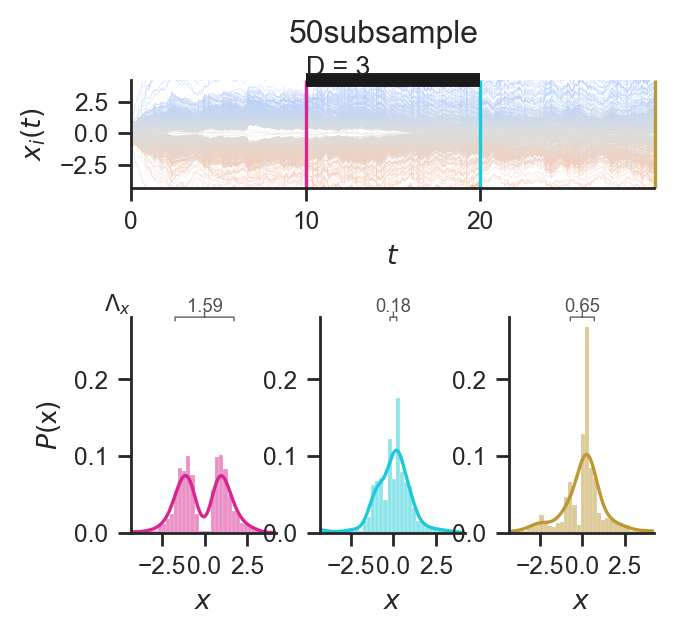

In [10]:
#@title Playground
%matplotlib inline
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.DEBUG)

noise_start = 10.
noise_length = 10.
recovery = 10.
num = 1
interval = 0

# Nudge arguments

D = 3 #@param {type:"slider", min:0, max:5, step:0.5}
sample_size = 50 #@param {type:"slider", min:0, max:50, step:1}
sample_method = "subsample" #@param ["basic", "subsample"]
seed = "1572039" #@param ["1337", "10725983", "7988657", "1572039", "15379820"] {allow-input: true}
update_conn = True #@param {type:"boolean"}
store_connections = True #@param {type:"boolean"}

# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 2 #@param {type:"slider", min:0, max:5, step:0.5}
K = 2 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
dt = 0.01

integration_method = "RK45" #@param ["Euler", "RK45"] {allow-input: true}

cls = "SampleChamber" #@param ["SampleChamber", "OpenChamber"]

cls_pick = {"SampleChamber": SampleChamber, "OpenChamber": OpenChamber}[cls]

kwargs = dict(N=N,
              m=m,
              activity_distribution = negpowerlaw,
              epsilon=ε,
              gamma=Υ,
              dt=dt,
              K=K,
              beta=β,
              alpha=α,
              r=r,
              update_conn=update_conn,
              store_all=store_connections,
              cls=cls_pick,
              method=integration_method,
              D=D,
              sample_size=sample_size,
              sample_method=sample_method,
              noise_start=noise_start,
              noise_length=noise_length,
              recovery=recovery,
              interval=interval,
              num=num,
              seed=int(seed)
             )

with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (3.375, 3)

    nsn = Simulation.run_periodic_noise(**kwargs, cache="all", plot_opinion=True)
    fig = plt.gcf()
    dist_axs = fig.axes[1:]
    for t, ax in zip([noise_start,noise_start+noise_length,noise_start+noise_length+recovery],
                     dist_axs):
        idx = np.argmin(np.abs(t - nsn.result.t)) if isinstance(t, float) else t
        opinions = nsn.result.y[:, idx]
        pop_dist = distribution_modality(opinions)
        ax.set_title("")

        y_max = ax.get_ylim()[1]
        color='grey'
        ax.annotate(f"{pop_dist:.2f}",
                    xy=(0, y_max),
                    xytext=(0, y_max*1.05),
                    arrowprops=dict(arrowstyle=f'-[,widthB={pop_dist}',
                                    color='k', alpha=0.7, lw=0.5),
                      alpha=0.8,
                    fontsize='x-small',
                    va='center',
                    ha='center')

        if t <= noise_start:
            ax.annotate(PEAK_DISTANCE, xy=(0,1), xycoords='axes fraction',
                        va='bottom', ha='right', fontsize='small')
    fig.savefig("output/delayed_noise_sample.pdf")
logging.getLogger().setLevel(logging_level)

periodic noise: 100%|█████████████████| 30.0/30.0 [07:20<00:00, 14.67s/it]


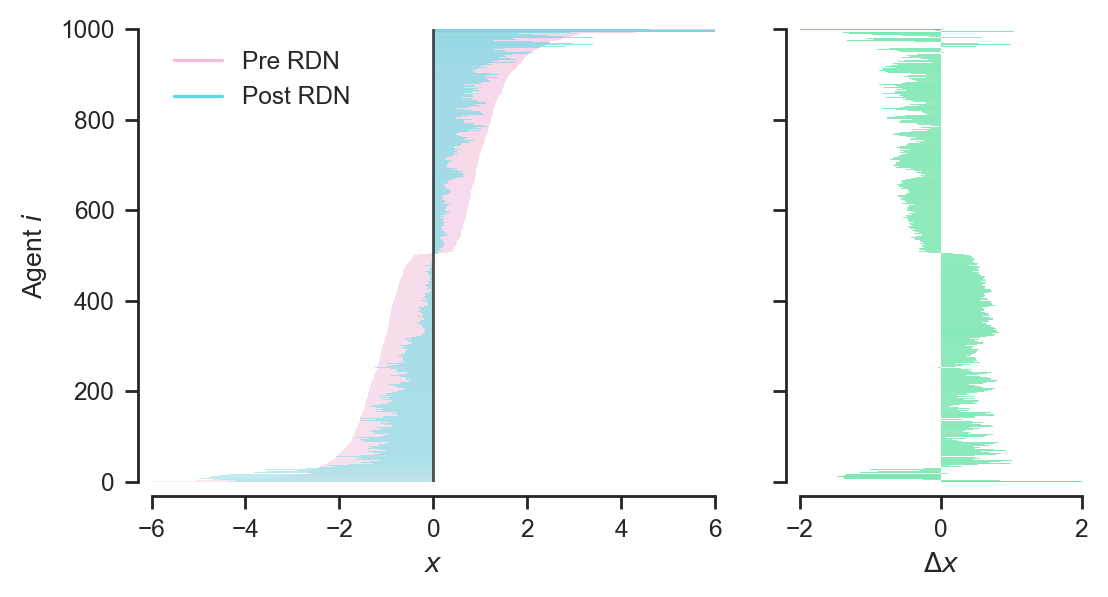

In [11]:
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from opdynamics.utils.plot_utils import colorbar_inset, colorline, get_time_point_idx
vis = VisSocialNetwork(nsn)

kwargs = {}

with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (6, 3)

    fig, axes = plt.subplots(ncols=2, sharex=False, sharey=True, 
                             gridspec_kw={"width_ratios": [1, 0.5]})

    t_point = float(noise_start)

    t_idx = get_time_point_idx(nsn.result.t, t_point)
    t_idx_end = get_time_point_idx(nsn.result.t, t_point+noise_length)

    pre_noise_opinions_unsorted = nsn.result.y[:, t_idx]
    post_noise_opinions_unsorted = nsn.result.y[:, t_idx_end]

    x_idx = np.argsort(pre_noise_opinions_unsorted)

    pre_noise_opinions = pre_noise_opinions_unsorted[x_idx]
    post_noise_opinions = nsn.result.y[x_idx, t_idx_end]
    change_in_opinions = post_noise_opinions - pre_noise_opinions

    cmap_pre = sns.light_palette(PRE_RDN_COLOR, n_colors=1, as_cmap=True)
    cmap_post = sns.light_palette(POST_RDN_COLOR, n_colors=1, as_cmap=True)
    # green and purple diverging colormap (white in middle)
    cmap_change = sns.diverging_palette(145, 300, s=-60, as_cmap=True)
    cmap_change = sns.light_palette(DELTA_RDN_COLOR, as_cmap=True)
    
    vmax = np.max(np.abs(change_in_opinions))
    vmin = -vmax
    v = vis._get_equal_opinion_limits()
    
    sm_change = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap_change)
    
    vis.show_agent_opinions(sort=x_idx, t=t_point, title=False, ax=axes[0],
                            colorbar=False, show_middle=False,
                            alpha=0.3,
                            cmap=cmap_pre,
                           )
    vis.show_agent_opinions(sort=x_idx, t=t_point+noise_length, title=False, ax=axes[0], 
                            alpha=0.7, colorbar=False, show_middle=False,
                            cmap=cmap_post
                           )

    axes[1].barh(
        np.arange(nsn.N),
        change_in_opinions,
        color=sm_change.to_rgba(np.abs(change_in_opinions)),
        edgecolor="None",
        linewidth=0,  # remove bar borders
        height=1,  # per agent
        alpha=0.8,
        **kwargs
    )
#     cbar = colorbar_inset(sm_change, "outer bottom", size="5%", pad=0.01, ax=axes[1])
    axes[0].set_xlim(-6,6)
    axes[1].set_xlim(-2,2)
    
#     axes[1].set_ylim(0, nsn.N)
#     axes[0].set_xscale("symlog")
#     axes[1].set_xscale("symlog")
    
    for ax in axes:
        sns.despine(ax=ax, offset=5)
#         ax.tick_params(axis="x", bottom=False, labelbottom=False)
    axes[1].set_xlabel(math_fix(f"$\Delta ${OPINION_SYMBOL}"))
    axes[0].legend([Line2D([],[], color=PRE_RDN_COLOR, alpha=0.3), Line2D([],[], color=POST_RDN_COLOR, alpha=0.7)],
                   ["Pre RDN", "Post RDN"], 
                  frameon=False)
    plt.savefig("output/dx.pdf")

(-5.0, 5.0)

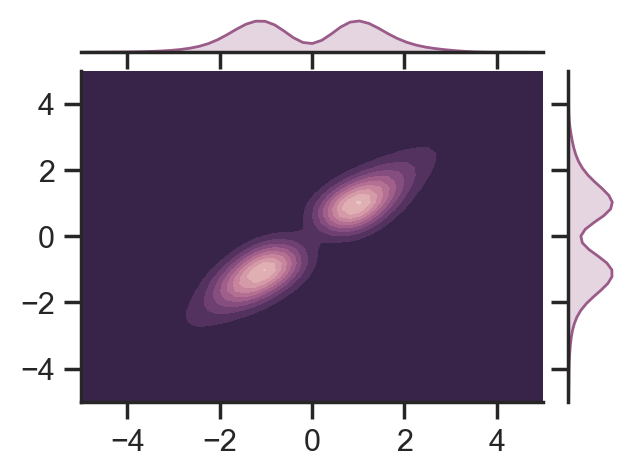

In [52]:
fig = plt.figure(figsize=(3.375, 2.618), dpi=200)
gs = gridspec.GridSpec(nrows=2, ncols=2, wspace=0.1, hspace=0.1,
                       left=0.18, right=0.97, bottom=0.15,
                       width_ratios=[1, 0.1], height_ratios=[0.1, 1],)
# create axes
ax_joint = fig.add_subplot(gs[1,0])
ax_marg_x = fig.add_subplot(gs[0,0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1,1], sharey=ax_joint)
sns.despine(ax=ax_marg_x, left=True)
sns.despine(ax=ax_marg_y, bottom=True)

show_jointplot(nsn.opinions_at_t(10.), nsn.get_nearest_neighbours(10.), ax=(ax_joint, ax_marg_x, ax_marg_y), 
               levels=10)
ax_joint.set_xlim(-5,5)
ax_joint.set_ylim(-5,5)

(-5.0, 5.0)

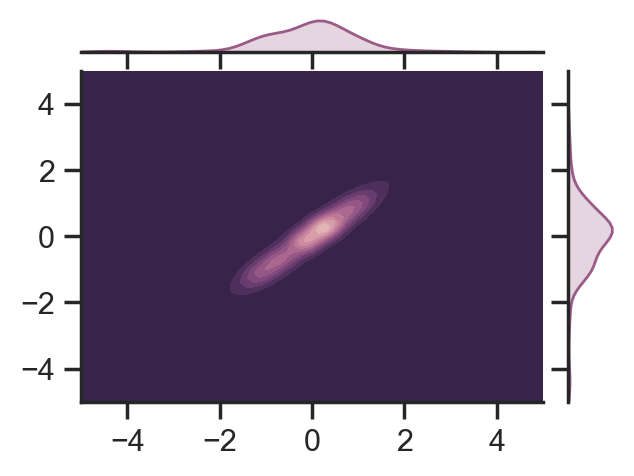

In [53]:
fig = plt.figure(figsize=(3.375, 2.618), dpi=200)
gs = gridspec.GridSpec(nrows=2, ncols=2, wspace=0.1, hspace=0.1,
                       left=0.18, right=0.97, bottom=0.15,
                       width_ratios=[1, 0.1], height_ratios=[0.1, 1],)
# create axes
ax_joint = fig.add_subplot(gs[1,0])
ax_marg_x = fig.add_subplot(gs[0,0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1,1], sharey=ax_joint)
sns.despine(ax=ax_marg_x, left=True)
sns.despine(ax=ax_marg_y, bottom=True)

show_jointplot(nsn.opinions_at_t(20.), nsn.get_nearest_neighbours(20.), ax=(ax_joint, ax_marg_x, ax_marg_y), 
               levels=10)
ax_joint.set_xlim(-5,5)
ax_joint.set_ylim(-5,5)

In [13]:
# get network properties

print("[0; noise start]")
G_start, df_start = nsn.get_network_agents((0.0, noise_start))
_, df_start_conn = nsn.get_network_connections((0.0, noise_start))
df_start["RDN"] = "Pre RDN"
df_start_conn["RDN"] = "Pre RDN"

print("[noise start; noise end]")
G_noise, df_noise = nsn.get_network_agents((noise_start, noise_start+noise_length))
_, df_noise_conn = nsn.get_network_connections((noise_start, noise_start+noise_length))
df_noise["RDN"] = "Post RDN"
df_noise_conn["RDN"] = "Post RDN"

print("[0, noise end]")
G_full_noise, df_full_noise = nsn.get_network_agents((0.0, noise_start+noise_length))
_, df_full_noise_conn = nsn.get_network_connections((0.0, noise_start+noise_length))

df_degree = pd.concat([df_start, df_noise], ignore_index=True)
df_conn = pd.concat([df_start_conn, df_noise_conn], ignore_index=True)

df_degree

[0; noise start]
[noise start; noise end]
[0, noise end]


,idx,opinion,in_degree,out_degree,degree,RDN
0,0,0.691279,253,317,570,Pre RDN
1,1,0.986507,297,392,689,Pre RDN
2,2,-1.764625,481,789,1270,Pre RDN
3,3,0.421083,272,248,520,Pre RDN
4,4,0.889939,326,439,765,Pre RDN
...,...,...,...,...,...,...
1995,995,-2.110110,667,1165,1832,Post RDN
1996,996,-0.478294,254,337,591,Post RDN
1997,997,-0.059828,217,221,438,Post RDN
1998,998,-0.577337,410,389,799,Post RDN


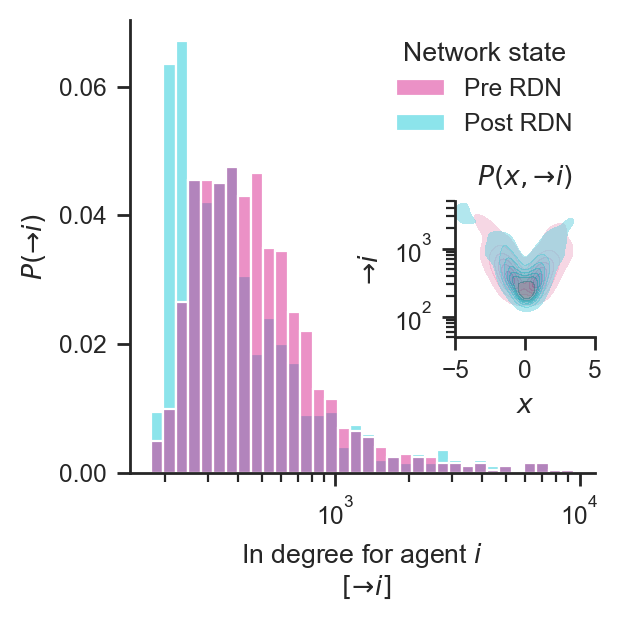

In [14]:
rdn_name = "Network state"
density_label = math_fix(f"$P(x,{IN_DEGREE_SYMBOL})$")

with sns.plotting_context("paper"):
    plt.rcParams["legend.frameon"] = False
    
    fig, ax = plt.subplots(figsize=(3,3), dpi=200)
    
    inset_ax = ax.inset_axes(bounds=[0.7, 0.3, 0.3, 0.3])
    
    sns.histplot(df_degree.rename(columns={"RDN":rdn_name}), x="in_degree", hue=rdn_name, palette=[PRE_RDN_COLOR, POST_RDN_COLOR], 
                log_scale=True, 
                stat="probability",
                ax=ax
               )
    
    ax.set(xlabel=f"In degree for agent $i$ \n " + math_fix(f"$[{IN_DEGREE_SYMBOL}]$"),
           ylabel=math_fix(f"$P({IN_DEGREE_SYMBOL})$"))
    
    sns.kdeplot(data=df_degree.rename(columns={"RDN":rdn_name}), x="opinion", y="in_degree", hue=rdn_name, palette=[PRE_RDN_COLOR, POST_RDN_COLOR], alpha=0.5, levels=8,  
                log_scale=(False, True), fill=True, legend=False,
                ax=inset_ax
               )
    
    inset_ax.set(xlim=(-5,5), ylim=(50, 5000), ylabel=IN_DEGREE_SYMBOL, xlabel=OPINION_SYMBOL, title=density_label)
    plt.savefig("output/in_degree.pdf")

C:\Users\ccurrin\dev\opinion_dynamics\opdynamics\utils\plot_utils.py:119: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return fig.colorbar(mappable, cax=ax_cbar, orientation=orientation, **kwargs)


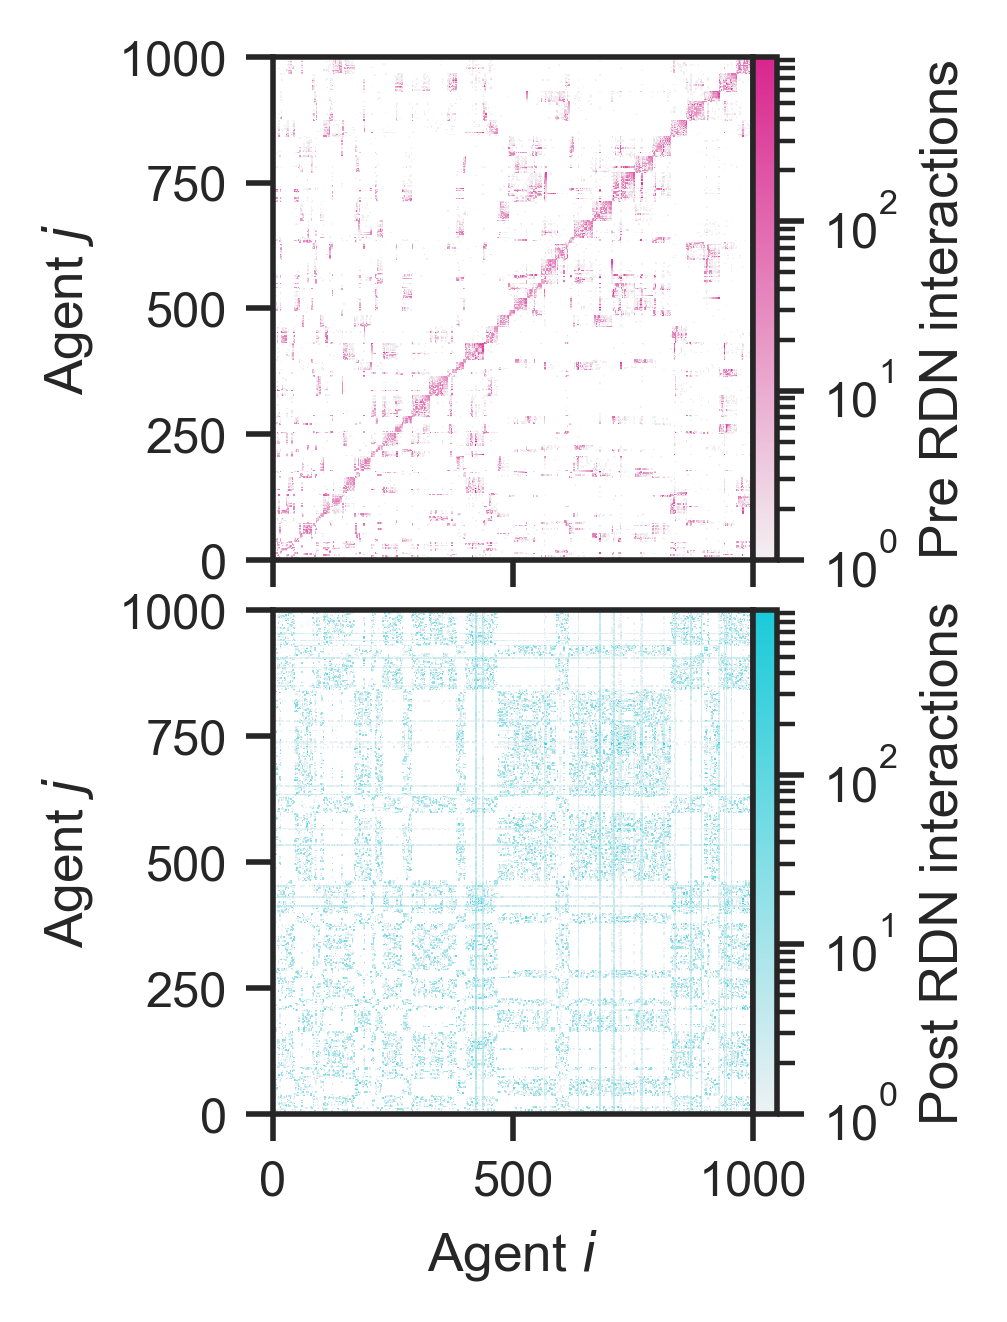

In [15]:
from matplotlib.colors import LogNorm, Normalize
from opdynamics.visualise.dense import show_matrix
from opdynamics.utils.plot_utils import get_time_point_idx
vis = VisSocialNetwork(nsn)

kwargs = {"map": "heatmap", "sort": True}
# vis.show_adjacency_matrix(title="Pre RDN", t=(0.0, noise_start), **kwargs)
# vis.show_adjacency_matrix(title="Post RDN", t=(noise_start, noise_start+noise_length), **kwargs)

acc_adj_mat_pre_rdn = nsn.adj_mat.accumulate(get_time_point_idx(nsn.result.t, (0.0, noise_start)))
acc_adj_mat_post_rdn = nsn.adj_mat.accumulate(get_time_point_idx(nsn.result.t,(noise_start, noise_start+noise_length)))

opinions_pre_rdn = nsn.result.y[:, get_time_point_idx(nsn.result.t, noise_start)]
opinions_post_rdn = nsn.result.y[:, get_time_point_idx(nsn.result.t, noise_start+noise_length)]

agent_mat_pre = pd.DataFrame(
    acc_adj_mat_pre_rdn,
    columns=pd.Index(nsn.agent_idxs, name="i"),
    index=pd.Index(nsn.agent_idxs, name="j"),
)
agent_mat_post = pd.DataFrame(
    acc_adj_mat_post_rdn,
    columns=pd.Index(nsn.agent_idxs, name="i"),
    index=pd.Index(nsn.agent_idxs, name="j"),
)

with sns.plotting_context("paper"):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(3, 3.5), dpi=400)
    fig.subplots_adjust(left=0.3, right=0.7, hspace=0.1)
    cbar_kws = dict(vmin=1, vmax=max(agent_mat_pre.values.max(), agent_mat_post.values.max()))

    fig, ax = show_matrix(agent_mat_pre, "Pre RDN interactions", map="mesh", sort=True, 
    #                       cmap="viridis", 
                          cmap=sns.light_palette(PRE_RDN_COLOR, as_cmap=True),
                          title="", rasterized=True,
                          ax=axes[0], **cbar_kws)
    axes[0].set_xlabel("")
    # access computed sorted dataframe (not present if sort=False)
    df_sorted_mat = show_matrix.sorted_mat

    # set to same index/columns as pre-rdn sorted matrix
    agent_mat_post = agent_mat_post.loc[df_sorted_mat.index, df_sorted_mat.columns]
    fig, ax = show_matrix(agent_mat_post, "Post RDN interactions", map="mesh", sort=False, 
    #                       cmap="viridis", 
                          cmap=sns.light_palette(POST_RDN_COLOR, as_cmap=True),
                          title="", rasterized=True,
                         ax=axes[1], zorder=-10, **cbar_kws)
    
#     delta_mat = np.abs(agent_mat_post-agent_mat_pre)
#     fig, ax = show_matrix(np.abs(agent_mat_pre-agent_mat_post), "Post RDN interactions", map="mesh", sort=True, 
# #                           cmap="viridis", 
#                           cmap=sns.light_palette(DELTA_RDN_COLOR, as_cmap=True),
#                           title="", rasterized=True, norm=LogNorm(), 
#                          ax=axes[1], vmin=1, vmax=delta_mat.values.max())
    
#     for ax in axes:
#         ax.set_rasterized(True)
#     fig.tight_layout()
    fig.savefig("output/interactions.pdf")
# fig, ax = show_matrix(agent_mat_pre, "Number of interactions", map="heatmap", sort=True, cmap="viridis", title="Pre RDN")
# fig, ax = show_matrix(agent_mat_post, "Number of interactions", map="heatmap", sort=True, cmap="viridis", title="Post RDN")



In [16]:
columns = ["opinion", "in_degree"]
df_change = df_noise[columns]-df_start[columns]
df_change.columns = [math_fix(f"$\Delta {OPINION_SYMBOL}$"), math_fix(f"$\Delta {IN_DEGREE_SYMBOL}$")]
df_change[[math_fix(f"|$\Delta {OPINION_SYMBOL}$|"), math_fix(f"|$\Delta$ {IN_DEGREE_SYMBOL}|")]] = df_change.abs()
df_change

,$\Delta x$,$\Delta → i$,|$\Delta x$|,|$\Delta → i$|
0,-0.443592,-19,0.443592,19
1,-0.605890,-77,0.605890,77
2,0.818480,-132,0.818480,132
3,-0.279839,-32,0.279839,32
4,-0.425382,-73,0.425382,73
...,...,...,...,...
995,0.298523,-3,0.298523,3
996,0.543327,-50,0.543327,50
997,0.520554,-46,0.520554,46
998,0.490251,-105,0.490251,105


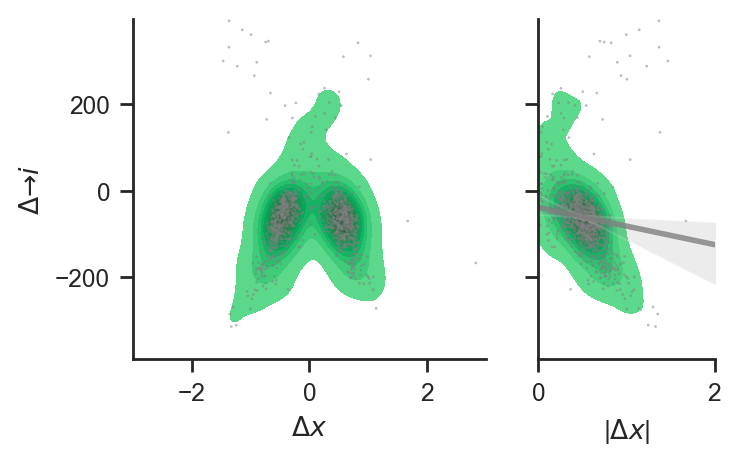

In [20]:
plot_scatter = True #@param {type:"boolean"}
absolute_y  = False #@param {type:"boolean"}

with sns.plotting_context("paper"):
    plt.rcParams["figure.dpi"] = 200
    
    fig, axes = plt.subplots(ncols=2, figsize=(3.75, 2.25), 
                             gridspec_kw={"width_ratios":[1,0.5]}, sharey=True)

    sns.kdeplot(data=df_change, x=df_change.columns[0], y=df_change.columns[1], 
                color=DELTA_RDN_COLOR, fill=True,
                ax=axes[0]
               )
    if plot_scatter:
        sns.scatterplot(data=df_change, x=df_change.columns[0], y=df_change.columns[1], 
                        color="grey", 
                        alpha=0.5, ec="None", s=1,
                        ax=axes[0]
                       )

    # absolutes

    sns.kdeplot(data=df_change, x=df_change.columns[2], y=df_change.columns[1+2*int(absolute_y)], 
                color=DELTA_RDN_COLOR, 
                ax=axes[1], fill=True,
               )
    if plot_scatter:
    #     sns.scatterplot(data=df_change, x=df_change.columns[2], y=df_change.columns[1+2*int(absolute_y)],
    #                     color="grey", 
    #                     alpha=0.5, sn="None", s=1,
    #                     ax=axes[1]
    #                    )
        sns.regplot(data=df_change, x=df_change.columns[2], y=df_change.columns[1+2*int(absolute_y)],
                        color="grey", 
                        scatter_kws=dict(alpha=0.5, ec="None", s=1,),
                        line_kws=dict(alpha=0.8, lw=2,),
                        ax=axes[1])

    axes[0].set(xlim=(-3,3), ylim=(axes[0].get_ylim()[0]/1.5, axes[0].get_ylim()[1]/1.5))
    axes[1].set(xlim=(0,2))
    plt.savefig("output/change_v_indegree.pdf")

## Range

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
from opdynamics.utils.cache import get_cache_dir, set_cache_dir
old_dir, new_dir = set_cache_dir(os.path.join("/content",".cache","delayed_noise"))

noise_start = 10.
noise_length = 10.
recovery = 10.
num = 1
interval = 0
seeds = [1337, 10725983, 7988657, 1572039, 15379820]
kwargs = dict(N=1000,
              m=10,
              activity_distribution = negpowerlaw,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.5,
              update_conn=True,
              cls=SampleChamber,
              method='RK45',
              D=5,
              sample_size=30,
              sample_method="basic",
              noise_start=noise_start,
              noise_length=noise_length,
              recovery=recovery,
              interval=interval,
              num=num,
             )
with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (3.375, 3)
    nec_list = Simulation.run_product(
            range_parameters={
                'D':{'range': [1, 3, 5]},
                'sample_size': {'range': [1, 30, 50]},
                'sample_method': {'range': ['basic', 'subsample']},
                'update_conn': {'range': [True]},
                'seed': {'range': seeds}
                },
            cache="all",
            cache_sim=False,
            parallel=True,
            plot_opinion=True,
            **kwargs)

old_dir, new_dir = set_cache_dir(old_dir)
logging.getLogger().setLevel(logging_level)

nec_dict = {}
for nsn in nec_list:
    key = (tuple(nsn._D_hist), nsn._sample_method[0], nsn._sample_size)
    nec_dict.setdefault(key, [])
    nec_dict[key].append(nsn)

In [ ]:
from tqdm.contrib import tenumerate
from matplotlib.cbook import flatten

num_seeds = len(seeds)

with sns.plotting_context("paper"):
    plt.rcParams["axes.titlesize"] = 'xx-small'
    plot_colors =  sns.color_palette("Set1", n_colors=num_seeds)
    fig, axs = plt.subplots(len(nec_dict.keys()), num_seeds+1,
                            figsize=(5, 15),
                            sharex="col", sharey="all",
                            )
    fig.subplots_adjust(hspace=0.3)
    sns.despine(fig, bottom=True)
    for i, key in tenumerate(sorted(nec_dict.keys())):
        print(key)
        for j, nsn in tenumerate(nec_dict[key]):
            _visec = VisSocialNetwork(nsn)
            title_key = f"{key[0][1][1]}, {key[1]}, {key[2]}"
            _visec.show_opinions("line", subsample=50,
                                 title=title_key,
                                 fig=fig, ax=axs[i,j])
            _visec.show_opinions_distribution(t=20, vertical=True, color=plot_colors[j],
                                   ax=axs[i, -1], title="",
                                   element="poly", stat="density")
            axs[i,j].axvline(20, ymin=-10, ymax=10, lw=0.5, c=plot_colors[j])
            axs[i,j].axvline(10, ymin=-10, ymax=10, ls='--', lw=0.5, c=plot_colors[j])
    for ax in flatten(axs[:, 1:]):
        ax.set_ylabel("")
    for ax in flatten(axs[:-1, :]):
        ax.set_xlabel("")

    axs[0,0].set_ylim(-5,5)
print("showing")


# Compare sample methods

In [91]:
from opdynamics.dynamics.opinions import clt_methods

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)
eclogger.setLevel(logging.INFO)


# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5 #@param {type:"slider", min:0, max:10, step:1}
# Nudge arguments
D = 1 #@param {type:"slider", min:0, max:20, step:0.5}
sample_size = 1 #@param {type:"slider", min:1, max:100, step:1}
seed_idx = -1 #@param {type:"slider", min:-1, max:20, step:1}
integration_method = "RK45" #@param ["Euler", "RK45"]

clt_method_names = [k for k in clt_methods.keys() if k is not None]

# custom sample methods
from opdynamics.metrics.opinions import sample_means

def custom_sample_basic2(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, n, num_samples=num_samples, rng=sn.rn) - np.mean(y)
    )

def custom_sample_n1v1000(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn) -
        sample_means(y, 1000, num_samples=num_samples, rng=sn.rn)
    )
def custom_sample_n1v100(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn) -
        sample_means(y, 100, num_samples=num_samples, rng=sn.rn)
    )
def custom_sample_n1vmean(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn) -
        np.mean(y)
    )
def custom_sample_n1v1(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn) -
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn)
    )
def custom_sample_n1v10(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=sn.rn) -
        sample_means(y, 10, num_samples=num_samples, rng=sn.rn)
    )
def custom_sample_n1v0(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = sample_means(y, 1, num_samples=num_samples, rng=sn.rn)
def custom_sample_n0v1(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = -sample_means(y, 1, num_samples=num_samples, rng=sn.rn)
def custom_sample_n0(sn, y: np.ndarray, n: int, num_samples: int):
    sn._sample_means = 0

clt_method_names += [
                   custom_sample_basic2,
                   custom_sample_n1v1000,
                   custom_sample_n1v100,
                   custom_sample_n1v10,
                   custom_sample_n1v1,
                   custom_sample_n1vmean,
                   custom_sample_n1v0,
                   custom_sample_n0v1,
                   custom_sample_n0]

# fig, ax = plt.subplots(len(clt_method_names), 1, 
# #                        gridspec_kw=dict(width_ratios=[1,0.1]),
#                        squeeze=False,
#                        sharey='row',
#                        sharex='col',
#                        figsize=(4, 8),
#                        dpi=200)
# fig.subplots_adjust(wspace=0.1, hspace=0.5)
# palette = sns.color_palette("husl", n_colors=len(clt_method_names))

seeds = np.geomspace(1, 100000, num=20, dtype=int)

if seed_idx>=0:
    seeds = [seeds[seed_idx]]

file_name = f"{get_cache_dir('sample_methods')}/df.h5"

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    seeds_completed = hdf.keys()
#     print(seeds_completed)
    for i, sample_method in enumerate(clt_method_names):
        for seed in seeds:
            sc = Simulation.run_params(cls=SampleChamber, N=N, m=m, K=K, alpha=α, beta=β,
                                       activity=activity_distribution, gamma=Υ, epsilon=ε,
                                       r=r, dt=dt, T=T,
                                       D=D, sample_size=sample_size, sample_method=sample_method,
                                       method=integration_method,
                                       plot_opinion=False,
                                       seed=seed,
                                       cache=True)
            title = sample_method if type(sample_method) is str else sample_method.__name__
            key = f"/{title}_{seed}_{hash(str(sc))}"
            if key in seeds_completed:
                continue
            temp_df = pd.DataFrame({OPINION_SYMBOL: sc.opinions})
            temp_df["Method"] = title
            hdf.append(f"{title}_{seed}_{hash(str(sc))}", temp_df)
#         meth_df = meth_df.append(temp_df, ignore_index=True)
        
#         vis = VisSocialNetwork(sc)
#     #     vis.show_opinions(color_code='line', ax=ax[i, 0],
#     #                       title=sample_method if type(sample_method) is str else sample_method.__name__)
#         vis.show_opinions_distribution(ax=ax[i, 0], vertical=False,
#                                        kde_kws=dict(bw_adjust=0.1), color=palette[i], 
#                                        title=title)
#         if i<len(clt_method_names):
#             ax[i,0].set_xlabel("")
#     #         ax[i,1].set_xlabel("")
#         ax[i,0].set_xlim(-5,5)
# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    meth_df = pd.concat([hdf.get(key) for key in hdf.keys()])

logging.getLogger().setLevel(logging_level)
    

INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThrea

write to file


INFO:MainThread:SocialNetwork:done running sample chamber
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_3_-8656870951361984229'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_6_-490875184879481912'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_127_-2464594754702679730'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
INFO:MainThread:SocialNetwork:done running sample chamber
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_233_-1432326312867524293'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_784_-7511735208964154240'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_4832_-4609799799459406927'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'custom_sample_basic2_54555_-7496635151649825459'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


write to file


INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber


write to file


INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThrea

INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber
INFO:MainThread:SocialNetwork:done running sample chamber


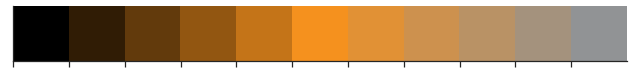

In [12]:
sns.palplot(sns.blend_palette(["#000", "#F6911E", "#919395"], 11))

In [99]:
str_names = [sample_method if type(sample_method) is str else sample_method.__name__ for sample_method in clt_method_names]
str_names = ['basic',
#  'outer_sigmoid',
#  'inner_sigmoid',
#  'subsample',
 'custom_sample_basic2',
 'custom_sample_n1v1000',
 'custom_sample_n1v100',
 'custom_sample_n1v10',
 'custom_sample_n1v1',
#  'custom_sample_n1vmean',
 'custom_sample_n1v0',
 'custom_sample_n0v1',
 'custom_sample_n0']
str_names

['basic',
 'custom_sample_basic2',
 'custom_sample_n1v1000',
 'custom_sample_n1v100',
 'custom_sample_n1v10',
 'custom_sample_n1v1',
 'custom_sample_n1v0',
 'custom_sample_n0v1',
 'custom_sample_n0']

In [100]:
label_map = {
 'basic': "$\\sqrt {n}\\left(\\langle X_{n} \\rangle-\\langle X \\rangle \\right)$",
 'custom_sample_basic2': "$\\langle X_{n} \\rangle-\\langle X \\rangle$",
 'outer_sigmoid': "$\\tanh{(\\sqrt{n} \\cdot \\left(\\langle X_{n} \\rangle-\\langle X \\rangle \\right)})$",
 'inner_sigmoid': "$\\sqrt{n} \\cdot \\tanh{\\left(\\langle X_{n} \\rangle -\\langle X \\rangle \\right)}$",
 'subsample': "$X_1 - \\langle X_{10}$",
 'custom_sample_n1v1000': "$X_1 - \\langle X_{N} \\rangle$",
 'custom_sample_n1v100': "$X_1 - \\langle X_{100} \\rangle$",
 'custom_sample_n1v10': "$X_1 - \\langle X_{10} \\rangle$",
 'custom_sample_n1v1': "$X_1 - X'_1$",
 'custom_sample_n1vmean': "$X_1 - \\langle X \\rangle$",
 'custom_sample_n1v0': "$X_1$",
 'custom_sample_n0v1': "$-X_1$",
 'custom_sample_n0': "$0$"
}

C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


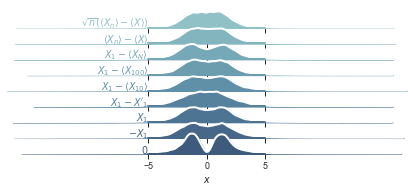

In [106]:
with sns.plotting_context("paper"):
    plt.rcParams["axes.facecolor"] = "None"
    pal = sns.cubehelix_palette(len(clt_method_names), rot=-.25, light=.7)
    g = sns.FacetGrid(meth_df, 
                      row="Method", row_order=str_names, 
                      hue="Method", hue_order=str_names, 
                      aspect=7, height=.3, palette=pal)
    
    bw_adjust = 0.5
    # Draw the densities in a few steps
    g.map(sns.kdeplot, OPINION_SYMBOL,
          bw_adjust=bw_adjust, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, OPINION_SYMBOL, clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label_map[label], fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)
    g.map(label, OPINION_SYMBOL)
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], xlim=(-5,5))
    g.despine(bottom=True, left=True)
#     g.axes.flat[-1].set_xticks(range(-4, 6,2))
    g.savefig("output/sample_methods.pdf")

# Other plot types

## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with
- $beta = 0.5$
- $r = 0.5$


In [ ]:
import os
import gc
eclogger.setLevel(logging.DEBUG)

beta = 0.5
r = 0.5

# how many simulations to run
num_states = 8
start = 0
stop = 4
K_range = np.round(np.linspace(start,stop,num_states), 2)
alpha_range = np.round(np.linspace(start,stop,num_states), 2)


# where to save the file
file_name = ".cache/K-alpha-phase.h5"

# the efficient HDF format is used for saving and loading DataFrames.
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K,alpha in tqdm(list(itertools.product(K_range,alpha_range))):
        sn = Simulation.run_params(SocialNetwork,N=N, m=m, K=K, alpha=alpha, beta=beta,
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T,
                                   store_all=False,
                                   cache=False, # don't cache full time of sim
                                   plot_opinion=False)
        t, mu = sn.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del sn
        gc.collect()
    df.to_hdf(file_name, key='df')

show_K_alpha_phase(df)
fig = plt.gcf()
fig.savefig("output/k-alpha-phase.pdf")

## Agent opinions at $t$

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_distribution(ax=ax[1], kde_kws=dict(fill=True))
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10,1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_distribution(ax=ax[1], kde_kws=dict(fill=False, bw_adjust=0.15), vertical=True)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', left=False, labelleft=False)

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10,1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_distribution(ax=ax[1], kde_kws=dict(fill=False, bw_adjust=0.15), vertical=True)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', left=False, labelleft=False)